# Search and Access NOAA@NSIDC IMS Data

As an example of a more generic search and remote access pattern, I will demonstrate creating time series of snow on the ground using the Interactive Multisensor Snow and Ice Mapping System (IMS) dataset.  This dataset contains daily maps of snow and ice cover for the Northern Hemisphere.

I use `fsspec`, which enables users to access local and remote filesystems common unified API (application programming interface), to interact with the HTTPS server.  Think of something like Doordash, which allows you to access many restaurants using a similar interface.  The IMS files are NetCDF. I use `xarray` and `rioxarray` to load the data as georeferenced grids.  I then extract snow cover from these grids for Fairbanks, AK, and Boulder, CO.  I use `geopandas` to make geospatial operations easier.  Finally, data are put into a `pandas` dataframe and plotted.

In [2]:
from pprint import pprint

import fsspec
import xarray as xr
import rioxarray

from shapely.geometry import Point
import pandas as pd
import geopandas

## Find available files

NOAA@NSIDC does not have a granule level catalog.  Ideally, all NSIDC data would be in a STAC (Spatiotemporal Assett Catalog).  However, we can create a barebones listing of IMS files.  IMS data comes in three "resolutions"; 1 km, 4 km and 24 km.  1 and 4 km data are in NetCDF.  The 24 km data are in ASCII grids.  I use the 4 km data here.

To start we need to know the URL for the 4 km data.  We can find this from [https://noaadata.apps.nsidc.org/NOAA/G02156/](https://noaadata.apps.nsidc.org/NOAA/G02156/).  We create a HTTPS virtual filesystem using `fsspec` and use the `find` method to find netcdf files.  I use the `endswith` string method inside a _list comprehension_.  Basically, we have a list of _things_, urls to files in this case, that we loop through adding them to another list, but only if the url ends-with "nc.gz".

This generates a list of IMS 4 km files.

In [3]:
%%time
NOAA_AT_NSIDC_URL = "https://noaadata.apps.nsidc.org/NOAA"
dataset = "G02156"
file_format = "netcdf"
resolution = "4km"

url = "/".join([NOAA_AT_NSIDC_URL, dataset, file_format, resolution])

fs = fsspec.filesystem("https")
filelist = [f for f in fs.find(url) if f.endswith("nc.gz")]  # to make sure we get only datafiles
print(len(filelist))
pprint(filelist[:10])

7303
['https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004056_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004057_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004058_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004059_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004060_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004061_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004062_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004063_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004064_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004065_4km_v1.2.nc.gz']
CPU times: user 174 ms, sys: 42.7 ms, total: 217 ms
Wall time: 4.57 s


### Load a file

As an example, I'll load the tenth file in the list of files.  We first open the file pointed to by the url using `fsspec.open`.  This creates a _file-like_ object that can be passed to xarray and opened as a `xarray.Dataset` data structure.  The `decode_coords="all"` indicates to `xarray` to look for georeferencing information (CRS, grid transform).

In [4]:
%%time
thisfile = filelist[10]
print(f"Opening {thisfile}")
f = fs.open(thisfile, compression="gzip")
ds = xr.open_dataset(f, decode_coords="all", chunks="auto")

Opening https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004066_4km_v1.2.nc.gz
CPU times: user 68.3 ms, sys: 29.6 ms, total: 97.9 ms
Wall time: 662 ms


We can now use the `xarray.Dataset`.

In [5]:
ds

<xarray.Dataset> Size: 151MB
Dimensions:             (x: 6144, y: 6144, time: 1)
Coordinates:
  * x                   (x) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                   (y) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * time                (time) datetime64[ns] 8B 2004-03-06
    projection          |S1 1B ...
Data variables:
    IMS_Surface_Values  (time, y, x) float32 151MB dask.array<chunksize=(1, 4096, 4096), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    04 May 2021 19:57Z: NetCDF file generated fro...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

In [7]:
ds.time.encoding

{'chunksizes': None,
 'fletcher32': False,
 'shuffle': False,
 'source': '<gzip File-like object HTTPFileSystem, https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004066_4km_v1.2.nc.gz 0x7f0bca4fe920>',
 'original_shape': (1,),
 'dtype': dtype('uint64'),
 'units': 'seconds since 1970-01-01T00:00:00Z'}

We can plot the data to make sure things look correct.  

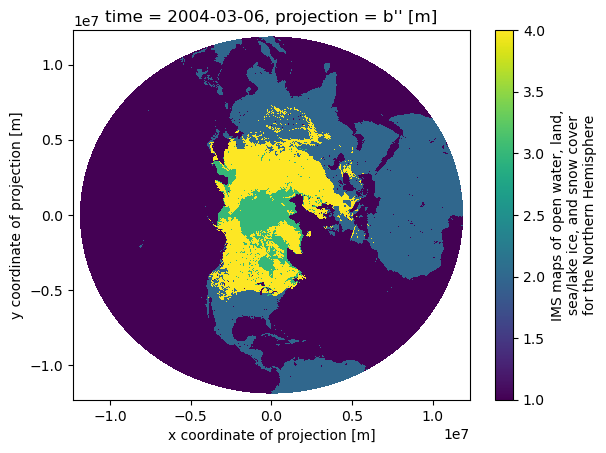

In [29]:
ds.IMS_Surface_Values.squeeze().plot.imshow(interpolation="none")

### Extract snow cover data for selected points

I want to be able to generate time series of snow on the ground for Fairbanks, AK, and Boulder, CO.  I use `geopandas` to create a series of points for these two locations, transform these points from latitude and longitude in WGS84 to the CRS for the IMS data.  This is really just a convenient workflow, and `geopandas` does so much more.

Geopandas extends the `pandas` package used for tabular data to include georefenced vector data.  Data can be transformed between different CRS and plotted on maps, which pretty much makes it a GIS.  

In [8]:
fairbanks = (-147.7200, 64.8401)  # Lat, Lon
boulder = (-105.2705, 40.0150)

points = geopandas.GeoSeries([Point(*fairbanks), Point(*boulder)], index=['Fairbanks', 'Boulder'], crs=4326)
points

Fairbanks    POINT (-147.72000 64.84010)
Boulder      POINT (-105.27050 40.01500)
dtype: geometry

We have the two locations as a `GeoSeries` in the WGS84 CRS.  We can easily convert it to the CRS for the IMS data.  Because we loaded `rioxarray` and used the `decode_coords="all"` keyword, a `crs` attribute was created that contains the IMS CRS.  This is accessed using the `rio.crs` accessor method.  I convert the CRS to a WKT (Well Known Text), which is a richer description of the CRS than a proj4 string.  If an EPSG code was available I would use that. 

In [9]:
points = points.to_crs(ds.rio.crs.to_wkt())
points

Fairbanks    POINT (-2464697.187 -1009841.072)
Boulder      POINT (-2370861.185 -5022286.682)
dtype: geometry

/home/apbarret/mambaforge/envs/project-demo-20240313/lib/python3.12/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


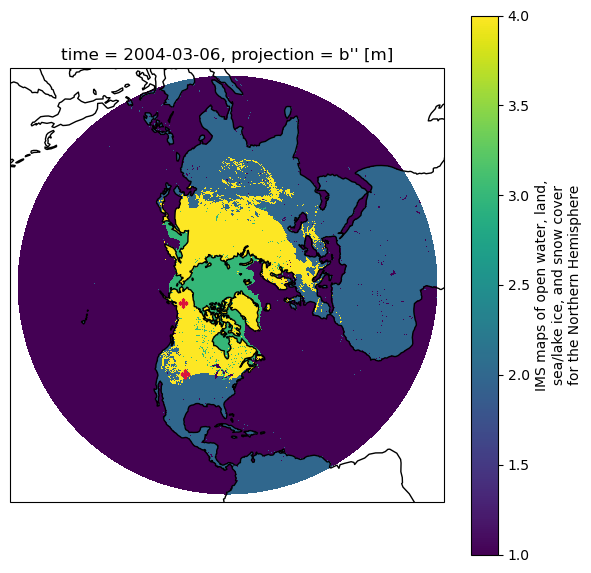

In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from nsidc_projections.grid import to_cartopy

# Set extent
extent = [ds.rio.bounds()[i] for i in [0,2,1,3]]
# Generate cartopy style crs
proj = to_cartopy(ds.rio.crs)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent(extent, proj)
ax.coastlines()

points.plot(ax=ax, marker='P', color='crimson', transform=proj)
ax.set_aspect('equal')
ds.IMS_Surface_Values.squeeze().plot.imshow(interpolation="none")


`xarray` objects have a `sel` method that allows single point indexing and slicing.  In this case, I want values for just the grid cells that contain the points of interest.  Normally, passing a list of points will return a region.  However, `xarray.Dataset.sel` has a vectorized indexing method that returns data for just the points but the index values need to be `xarray.DataArray` objects.  Geopandas has a `to_xarray` method that we apply to the `x` and `y` coordinates of `points`.

In [35]:
x = points.x.to_xarray()
y = points.y.to_xarray()
x, y

(<xarray.DataArray (index: 2)> Size: 16B
 array([-2464697.18746901, -2370861.18538626])
 Coordinates:
   * index    (index) object 16B 'Fairbanks' 'Boulder',
 <xarray.DataArray (index: 2)> Size: 16B
 array([-1009841.0721793 , -5022286.68248111])
 Coordinates:
   * index    (index) object 16B 'Fairbanks' 'Boulder')

Closest grid cells to the points are found by setting the `method="nearest"`.  This returns an `xarray.DataArray` containing the `IMS_Surface_Values` for the grid cells closest to the points of interest.

In [36]:
surface = ds.IMS_Surface_Values.sel(x=x, y=y, method="nearest")
surface

<xarray.DataArray 'IMS_Surface_Values' (time: 1, index: 2)> Size: 8B
dask.array<transpose, shape=(1, 2), dtype=float32, chunksize=(1, 2), chunktype=numpy.ndarray>
Coordinates:
    x           (index) float32 8B -2.466e+06 -2.37e+06
    y           (index) float32 8B -1.01e+06 -5.022e+06
  * time        (time) datetime64[ns] 8B 2004-03-06
    projection  |S1 1B ...
  * index       (index) object 16B 'Fairbanks' 'Boulder'
Attributes:
    short_name:     IMS Surface Values
    standard_name:  area_type
    long_name:      IMS maps of open water, land, sea/lake ice, and snow cove...
    comment:        0: Outside Coverage Area, 1: Open Water, 2: Land Without ...
    flag_values:    [0 1 2 3 4]
    flag_meanings:  outside_coverage_area open_water snow_free_land lake_ice_...

Inspecting the data values, we can see that two points are returned for 2004-03-06.  The `flag_meanings` attribute indicates that Fairbanks was snow covered and Boulder was snow free.  Not a huge surprise!

In [38]:
surface.values

array([[4., 4.]], dtype=float32)

To streamline the procedure to extract surface cover for a year of IMS data, we define two functions; one to extract points from each dataset, and one to open each file and call the `extract_from_dataset` function.  The results are converted back to a `pandas.DataFrame` because we are dealing with tabular data - really two time series of surface cover, one for each location.

In [39]:
def extract_from_dataset(ds, x, y):
    surface = ds.IMS_Surface_Values.sel(x=x, y=y, method="nearest")
    df = surface.drop_vars(['x', 'y', 'projection']).to_dataframe().unstack(level=-1)
    return df.droplevel(level=0, axis=1)

def extract_from_file(href, x, y):
    with fs.open(href, compression="gzip") as f:
        with xr.open_dataset(f, decode_coords="all") as ds:
            df = extract_from_dataset(ds, x, y)
    return df

We can subset the list of files on HTTPS using anoth _list comprehension_.  We'll use 2023 as an example.

In [40]:
thesefiles = [f for f in filelist if "/2023/" in f]
len(thesefiles)

365

We can then loop through all the files for 2023, extracting the data for Fairbanks and Boulder.  The results are concatenated into a single `DataFrame`.

In [41]:
%%time
df = pd.concat([extract_from_file(href, x, y) for href in thesefiles])
df

CPU times: user 18.3 s, sys: 641 ms, total: 19 s
Wall time: 6min 40s


index,Fairbanks,Boulder
time,,
2023-01-01,4.0,4.0
2023-01-02,4.0,4.0
2023-01-03,4.0,4.0
2023-01-04,4.0,4.0
2023-01-05,4.0,4.0
...,...,...
2023-12-27,4.0,4.0
2023-12-28,4.0,4.0
2023-12-29,4.0,2.0


Finally we can plot the results.

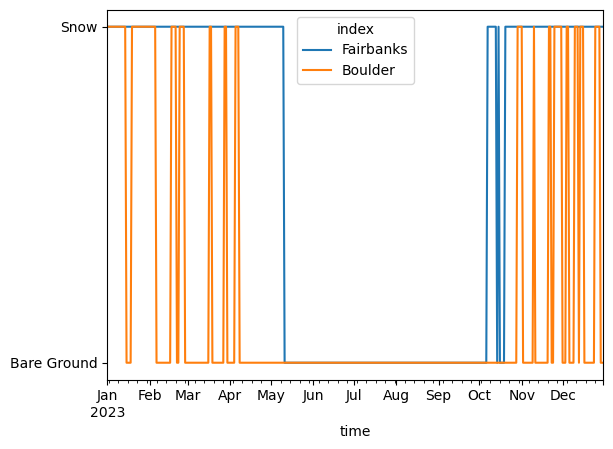

In [42]:
ax = df.plot()
ax.set_yticks([2., 4], ["Bare Ground", "Snow"]);